# <div style="padding:20px;color:white;margin:0;font-size:50px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#000850;overflow:hidden"><b>Rice image classification</b></div>

<h5 style="text-align: center; font-family: Verdana; font-size: 12px; font-style: normal; font-weight: bold; text-decoration: None; text-transform: none; letter-spacing: 1px; color: #254E58; background-color: #ffffff;">Mikołaj Pawlak</h5>

<h5 style="text-align: center;padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#000850;overflow:hidden">The task is to train neural network to correctly classify rice type based on given image. Google Colab was used to run this code.</h5>

<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:35px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#000814;overflow:hidden"><b>Table of content</b></div>

<div style="background-color:#FCFBF4; padding:30px; font-size:15px;color:#034914">

1. [Download the kaggle data](#1)
    
2. [Load and inspect the data with pytorch](#2)
    
3. [Prepare transforms and split data for train and test](#3)
    
4. [Define Neural Network model](#4)
    
5. [Define loss function, optimizer, train and test loops](#5)

6. [Train model](#6)

7. [Evaluate model](#7)

8. [Calculate final benchmarks](#8)

9. [Save the model](#9)
</div>

<a id="1"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#000814;overflow:hidden"> 1. Download the kaggle data</div>
# <h6 style="font-size: 15px;">Link to the dataset: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset/code?datasetId=2049052&sortBy=voteCount</h6>

In [ ]:
# Upload Kaggle API configuration
from google.colab import files
files.upload()

In [2]:
!mkdir -p ~/.kaggle  # create directory .kaggle in my home folder if it doesnt exist
!mv kaggle.json ~/.kaggle/ # move kaggle.json to uploaded directory
!chmod 600 ~/.kaggle/kaggle.json # set perissions of the fule so that only i can read/write it

In [3]:
!pip install -q kaggle

In [ ]:
!kaggle datasets download -d muratkokludataset/rice-image-dataset
!unzip rice-image-dataset.zip -d rice_data

<a id="2"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#000814;overflow:hidden"> 2. Load and inspect the data with pytorch</div>

In [5]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, Subset

transform = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor()
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     #std=[0.229, 0.224, 0.225])  ## DEFAULT RGB NORMALIZATION
])
### TODO do a quick model without custom transforms and splits and others ..
dataset = ImageFolder(root = "/content/rice_data/Rice_Image_Dataset", transform = transform)
loader = DataLoader(dataset, batch_size = 32, shuffle = True)

In [6]:
unique_classes = len(dataset.classes)
print("Class names:", dataset.classes)
print("Class-to-index mapping:", dataset.class_to_idx)

from collections import Counter
print("Class distribution:", Counter(dataset.targets))

Class names: ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
Class-to-index mapping: {'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}
Class distribution: Counter({0: 15000, 1: 15000, 2: 15000, 3: 15000, 4: 15000})


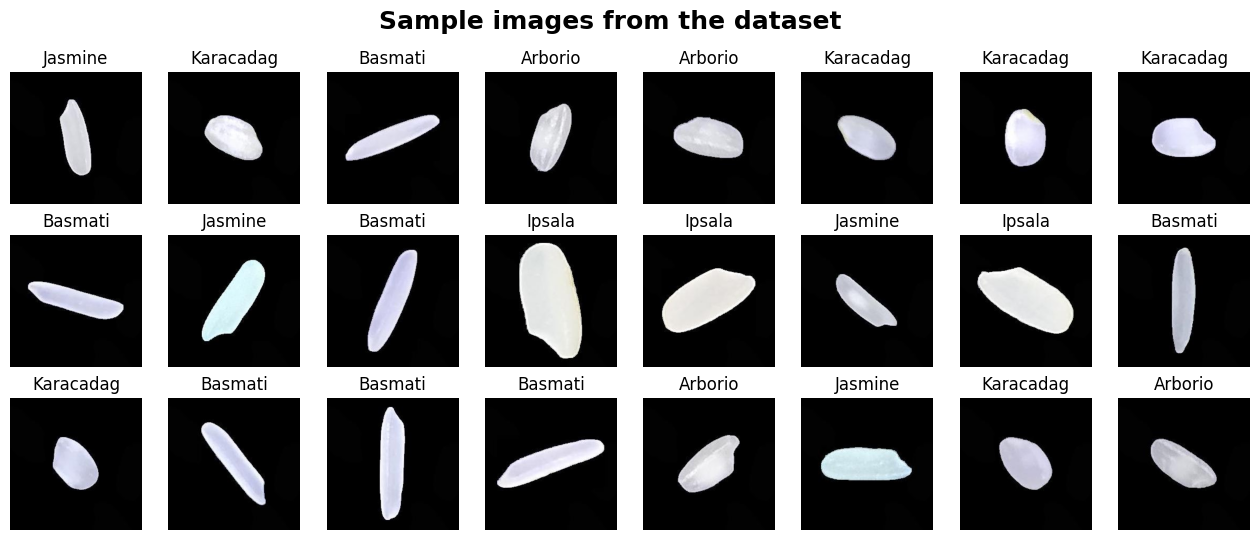

In [7]:
import matplotlib.pyplot as plt
import torch

# Visualize sample from dataset

# Get one shuffled batch from the dataloader
images, labels = next(iter(loader))

plt.figure(figsize=(16,6))
plt.suptitle("Sample images from the dataset", fontsize = 18, fontweight = "bold")

for i in range(min(24, len(images))):
  ax = plt.subplot(3, 8, i+1)

  # Ensure RGB order (C, H, W) → (H, W, C)
  img = torch.permute(images[i].clone(), (1, 2, 0))
  plt.imshow(img)

  # Map label index to class name
  label = list(dataset.class_to_idx.keys())[list(dataset.class_to_idx.values()).index(labels[i].item())]

  plt.title(label)
  plt.axis('off')
plt.show()


<a id="3"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#000814;overflow:hidden"> 3. Prepare transforms and split data for train and test</div>

In [8]:
# Calculate this dataset mean and std to Normalize the data
from tqdm import tqdm

mean = 0.
std = 0.
nb_samples = 0.

for data, _ in tqdm(loader, desc="Computing mean/std"): # data is (batch_size, channels, height, width)
  batch_samples = data.size(0) # gets number of images
  data = data.view(batch_samples, data.size(1), -1) # flatten height and width to one dimention (h*w)
  mean += data.mean(2).sum(0) # mean across pixels (batch_size, channels), sum across batch: (channels,2)
  std += data.std(2).sum(0)

mean /= len(loader.dataset)
std /= len(loader.dataset)

print("Mean:", mean)
print("Std:", std)

Computing mean/std: 100%|██████████| 2344/2344 [03:24<00:00, 11.44it/s]

Mean: tensor([0.1179, 0.1189, 0.1229])
Std: tensor([0.2851, 0.2875, 0.2989])


In [9]:
# Use calculated mean and std to normalize the data
# Normalized data helps gradient descent converge faster and more stably (NN are sensitive to the scale and distribution of input data)
# Additionaly it reduces bias from lighting or contract
#mean = [0.1179, 0.1189, 0.1229]
#std  = [0.2824, 0.2848, 0.2963]

# Prepare transforms (add data augmentation for train)
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# load two copies of the same dataset with diffrent transforms
train_dataset = ImageFolder(root = "/content/rice_data/Rice_Image_Dataset", transform = train_transform)
test_dataset = ImageFolder(root = "/content/rice_data/Rice_Image_Dataset", transform = test_transform)

In [10]:
# Ensure splits have balanced classes
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2
BATCH_SIZE = 64
SEED = 42

# generate indices
train_indices, test_indices, _, _ = train_test_split(
    range(len(dataset)),
    dataset.targets,
    test_size = TEST_SIZE,
    stratify = dataset.targets,
    random_state = SEED
)

# generate subset based on idices
train_split = Subset(train_dataset, train_indices)
test_split = Subset(test_dataset, test_indices)

# create separate dataloaders
# (the data was already transformed in dataset)
train_dataloader = DataLoader(train_split, batch_size = BATCH_SIZE, shuffle = True, num_workers=2)
test_dataloader = DataLoader(test_split, batch_size = BATCH_SIZE, num_workers=2) # do not use shuffle for test set

In [11]:
import matplotlib.pyplot as plt
from collections import Counter

def count_labels(dataloader) -> Counter:
  all_labels = []
  for _, labels in tqdm(dataloader, desc="Counting labels", total=len(dataloader)):
    all_labels.extend(labels.numpy()) # convert to numpy and flatten

  class_counts = Counter(all_labels)
  return class_counts
def plot_class_distribution(class_counts: Counter, plt_tile:str = "Class Distribution in Train Dataloader"):
  labels = [f"Class {k}" for k in class_counts.keys()]
  sizes = [v for v in class_counts.values()]
  total = sum(sizes)

  plt.figure(figsize = (3,3))
  plt.pie(sizes, labels=[f"{lbl}\n{cnt} ({cnt/total:.1%})" for lbl,cnt in zip(labels,sizes)],
          autopct=None, startangle=140)
  plt.title(plt_tile)
  plt.axis("equal")
  plt.show()

In [12]:
train_counter = count_labels(train_dataloader)
test_counter = count_labels(test_dataloader)

Counting labels: 100%|██████████| 235/235 [00:16<00:00, 14.32it/s]


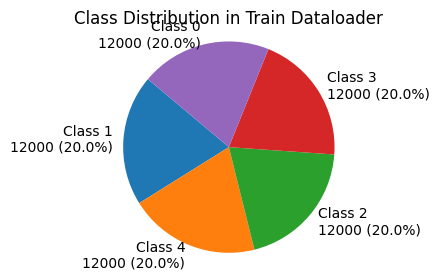

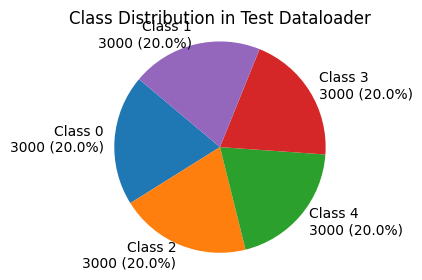

In [13]:
plot_class_distribution(train_counter, "Class Distribution in Train Dataloader")
print("\n")
plot_class_distribution(test_counter, "Class Distribution in Test Dataloader")

<a id="4"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#000814;overflow:hidden"> 4. Define Neural Network model</div>

In [14]:
import os
import torch
from torch import nn

In [15]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [17]:
# Define model
class NeuralNetwork(nn.Module):
  def __init__ (self, unique_classes):
    super().__init__()
    self.flatten = nn.Flatten() #converts the input tensor to 1D
    self.avgpool = nn.AdaptiveAvgPool2d((1,1)) # helps with high memory cost, but model may learn less
    self.conv_layers = nn.Sequential(
        # Input: id_channels = 3 (RGB)
        # Output: out_channels = 32 (number of feature maps the layer will learn)
        # Kernel_size = size of filter window (common 3x3 and 5x5). Larger kernel = wider receptive field = more context per layer.
        # Stride (default 1) - Bigger stride → downsampling → smaller output. Speeds up computation
        # Padding (defalut 0) - Adds zero (or reflect) borders to keep output size the same.
        # with 3x3 kernel use 1, with 5x5 use 2. Without padding spatial size shrinks each row. TODO read
        # bias (default True) - If True, adds a learnable bias to each output channel. If followed by BatchNorm, it’s common to set bias=False (because BatchNorm has its own learnable shift).
        nn.Conv2d(3, 32, kernel_size = 3, padding = 1), # Extract features from the image (edges, textures, shapes)
        nn.BatchNorm2d(32), # Normalizes activations → helps training converge faster and more stable.
                            # lower sensitivity to learning rate and other.
                            # if it was after pooling it would reduce its effectivnes since pooling loses spatial information
                            # if it was after ReLU it was meaningless - i'll be normalizing already clamped values (no negatives)
        nn.ReLU(),
        nn.MaxPool2d(2), # Downsamples the spatial dimentions reducing computation and increasing receptive field
        nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.dense_layers = nn.Sequential(
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Dropout(0.3), # Regularization -> minimize risk of overfitting, if set to 0.5 it would might help with generalization (but too much hurts small data)
        nn.Linear(128, 128),  ## could make smaller (128,64)
        nn.ReLU(),
        nn.Linear(128, unique_classes)  ### could make smaller (64)
    )

  def forward(self, X):
    out = self.conv_layers(X)
    ### ALTERNATIVE out = out.view(out.size(0), -1) # feeds model all spatial information into dense layer, so preserves full detail but:
    # Highly dependent on input size and conv output shape
    # Can result in a very large dense layer, wasting parameters and memory
    # Overfitting risk increases
    # Option 1: use only that
    # Option 2:  out = self.avgpool(out) and out = self.flatten(out)
    out = self.avgpool(out) # Shrinks HxW to 1x1 shape: (B, C, 1, 1)
    out = self.flatten(out) # shape (B, C)
    logits = self.dense_layers(out)
    return logits

model = NeuralNetwork(unique_classes)

<a id="5"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#000814;overflow:hidden"> 5. Define loss function, optimizer, train and test loops</div>

In [18]:
# Optimization
LEARNING_RATE = 1e-3
BATCH_SIZE = 65
EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = LEARNING_RATE)

In [19]:
import numpy as np
from datetime import datetime
from tqdm import tqdm

def train_loop(dataloader, model, loss_fn, optimizer, epoch, device):
    model.train()
    size = len(dataloader.dataset)

    total_loss = 0.0
    n_correct = 0
    n_total = 0

    for batch, (X, y) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1} - Training")):
        X, y = X.to(device), y.to(device)

        # Forward
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        total_loss += loss.item() * X.size(0)
        _, predicted = torch.max(pred, 1)
        n_correct += (predicted == y).sum().item()
        n_total += y.size(0)

    avg_loss = total_loss / size
    accuracy = n_correct / n_total
    return avg_loss, accuracy


def test_loop(dataloader, model, loss_fn, epoch, device):
    model.eval()
    size = len(dataloader.dataset)
    total_loss = 0.0
    n_correct = 0

    with torch.no_grad():
        for X, y in tqdm(dataloader, desc=f"Epoch {epoch+1} - Validation"):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)

            total_loss += loss.item() * X.size(0)
            _, predicted = torch.max(pred, 1)
            n_correct += (predicted == y).sum().item()

    avg_loss = total_loss / size
    accuracy = n_correct / size
    return avg_loss, accuracy


<a id="6"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#000814;overflow:hidden"> 6. Train model</div>

In [20]:
# Loop controller
EPOCHS = 20
train_losses = []
val_losses = []
train_accs = []
val_accs = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

best_val_loss = float('inf')
patience = 3 # early_stopping_limit
epochs_no_improve = 0 # count
best_model_state = None

t0 = datetime.now()

for epoch in range(EPOCHS):
    train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer, epoch, device)
    val_loss, val_acc = test_loop(test_dataloader, model, loss_fn, epoch, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")
# val loss and acc because it is during training
# val is to tune hyperparameters & detect overfitting
# val can change during tuning/early stopping
# test loss and acc is after trainign to evaluate final performance
# test should be only once - a final report card

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs.")
            break

duration = datetime.now() - t0

if best_model_state is not None:
    model.load_state_dict(best_model_state)

Epoch 1 - Validation: 100%|██████████| 235/235 [00:13<00:00, 16.98it/s]



Epoch 1 Summary:
Train Loss: 1.5811, Train Acc: 0.3232
Val   Loss: 1.5377, Val   Acc: 0.3990


Epoch 2 - Validation: 100%|██████████| 235/235 [00:13<00:00, 17.90it/s]



Epoch 2 Summary:
Train Loss: 1.4706, Train Acc: 0.4096
Val   Loss: 1.3627, Val   Acc: 0.4897


Epoch 3 - Validation: 100%|██████████| 235/235 [00:13<00:00, 17.09it/s]



Epoch 3 Summary:
Train Loss: 1.2565, Train Acc: 0.5318
Val   Loss: 1.1201, Val   Acc: 0.5983


Epoch 4 - Validation: 100%|██████████| 235/235 [00:13<00:00, 17.41it/s]



Epoch 4 Summary:
Train Loss: 1.0300, Train Acc: 0.6682
Val   Loss: 0.8879, Val   Acc: 0.7473


Epoch 5 - Validation: 100%|██████████| 235/235 [00:13<00:00, 17.29it/s]



Epoch 5 Summary:
Train Loss: 0.7961, Train Acc: 0.7904
Val   Loss: 0.6282, Val   Acc: 0.8819


Epoch 6 - Validation: 100%|██████████| 235/235 [00:13<00:00, 16.93it/s]



Epoch 6 Summary:
Train Loss: 0.5609, Train Acc: 0.8685
Val   Loss: 0.4102, Val   Acc: 0.9342


Epoch 7 - Validation: 100%|██████████| 235/235 [00:17<00:00, 13.57it/s]



Epoch 7 Summary:
Train Loss: 0.4020, Train Acc: 0.8980
Val   Loss: 0.2775, Val   Acc: 0.9495


Epoch 8 - Validation: 100%|██████████| 235/235 [00:13<00:00, 17.39it/s]



Epoch 8 Summary:
Train Loss: 0.3108, Train Acc: 0.9145
Val   Loss: 0.2000, Val   Acc: 0.9678


Epoch 9 - Validation: 100%|██████████| 235/235 [00:13<00:00, 17.61it/s]



Epoch 9 Summary:
Train Loss: 0.2533, Train Acc: 0.9269
Val   Loss: 0.1740, Val   Acc: 0.9624


Epoch 10 - Validation: 100%|██████████| 235/235 [00:13<00:00, 17.08it/s]



Epoch 10 Summary:
Train Loss: 0.2114, Train Acc: 0.9394
Val   Loss: 0.1363, Val   Acc: 0.9723


Epoch 11 - Validation: 100%|██████████| 235/235 [00:13<00:00, 17.20it/s]



Epoch 11 Summary:
Train Loss: 0.1837, Train Acc: 0.9476
Val   Loss: 0.1033, Val   Acc: 0.9768


Epoch 12 - Validation: 100%|██████████| 235/235 [00:13<00:00, 17.45it/s]



Epoch 12 Summary:
Train Loss: 0.1564, Train Acc: 0.9544
Val   Loss: 0.0924, Val   Acc: 0.9797


Epoch 13 - Validation: 100%|██████████| 235/235 [00:13<00:00, 17.05it/s]



Epoch 13 Summary:
Train Loss: 0.1418, Train Acc: 0.9577
Val   Loss: 0.0928, Val   Acc: 0.9715


Epoch 14 - Validation: 100%|██████████| 235/235 [00:13<00:00, 17.25it/s]



Epoch 14 Summary:
Train Loss: 0.1254, Train Acc: 0.9623
Val   Loss: 0.0837, Val   Acc: 0.9771


Epoch 15 - Validation: 100%|██████████| 235/235 [00:13<00:00, 17.53it/s]



Epoch 15 Summary:
Train Loss: 0.1180, Train Acc: 0.9651
Val   Loss: 0.0569, Val   Acc: 0.9867


Epoch 16 - Validation: 100%|██████████| 235/235 [00:13<00:00, 17.13it/s]



Epoch 16 Summary:
Train Loss: 0.1087, Train Acc: 0.9675
Val   Loss: 0.0530, Val   Acc: 0.9861


Epoch 17 - Validation: 100%|██████████| 235/235 [00:13<00:00, 17.60it/s]



Epoch 17 Summary:
Train Loss: 0.0999, Train Acc: 0.9704
Val   Loss: 0.0575, Val   Acc: 0.9836


Epoch 18 - Validation: 100%|██████████| 235/235 [00:13<00:00, 17.08it/s]



Epoch 18 Summary:
Train Loss: 0.0933, Train Acc: 0.9721
Val   Loss: 0.0476, Val   Acc: 0.9868


Epoch 19 - Validation: 100%|██████████| 235/235 [00:13<00:00, 17.63it/s]



Epoch 19 Summary:
Train Loss: 0.0849, Train Acc: 0.9745
Val   Loss: 0.0408, Val   Acc: 0.9891


Epoch 20 - Validation: 100%|██████████| 235/235 [00:13<00:00, 17.43it/s]


Epoch 20 Summary:
Train Loss: 0.0842, Train Acc: 0.9744
Val   Loss: 0.0454, Val   Acc: 0.9878


<a id="7"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#000814;overflow:hidden"> 7. Evaluate model</div>

**Training and validation interpretation**  
  
First epoch:
- Train loss (1.5811) - the lower the better, 1.5 + on first epoch can be normal with 5 classes
- Train Acc (0.3232) - model correctly classifies ~32% of cases. For 5 classes random guess is 20%, so the model is actually learning something
- Val loss (1.5377) - validation loss is lower than training loss, our model generalizes knowledgde quite well
- Val Acc (0.3990) - better than training one


Smooth curve

No signs of overfitting

Train/val match closely

**Final accuracy** is highly promising, reaching **0.9878**.

In [21]:
# Result logging
import pandas as pd
from tabulate import tabulate

history = {
    'Train_Loss': train_losses,
    'Validation_Loss': val_losses,
    'Train_Accuracy': train_accs,
    'Validation_Accuracy': val_accs,
    'Epoch': list(range(1, EPOCHS + 1))
}

result_df = pd.DataFrame(history)
result_df.to_excel('result.xlsx', index=False)
print(tabulate(result_df, headers='keys', tablefmt='psql'))
print(f"\nTotal training duration: {duration}")

+----+--------------+-------------------+------------------+-----------------------+---------+
|    |   Train_Loss |   Validation_Loss |   Train_Accuracy |   Validation_Accuracy |   Epoch |
|----+--------------+-------------------+------------------+-----------------------+---------|
|  0 |    1.58114   |         1.5377    |         0.323167 |              0.399    |       1 |
|  1 |    1.47065   |         1.36272   |         0.40955  |              0.489733 |       2 |
|  2 |    1.25651   |         1.12011   |         0.5318   |              0.598333 |       3 |
|  3 |    1.03003   |         0.887881  |         0.66815  |              0.747267 |       4 |
|  4 |    0.796053  |         0.628196  |         0.790417 |              0.881867 |       5 |
|  5 |    0.560858  |         0.41024   |         0.868467 |              0.9342   |       6 |
|  6 |    0.401997  |         0.277523  |         0.897983 |              0.949533 |       7 |
|  7 |    0.310835  |         0.199995  |         

In [28]:
epochs = list(range(1, 21))

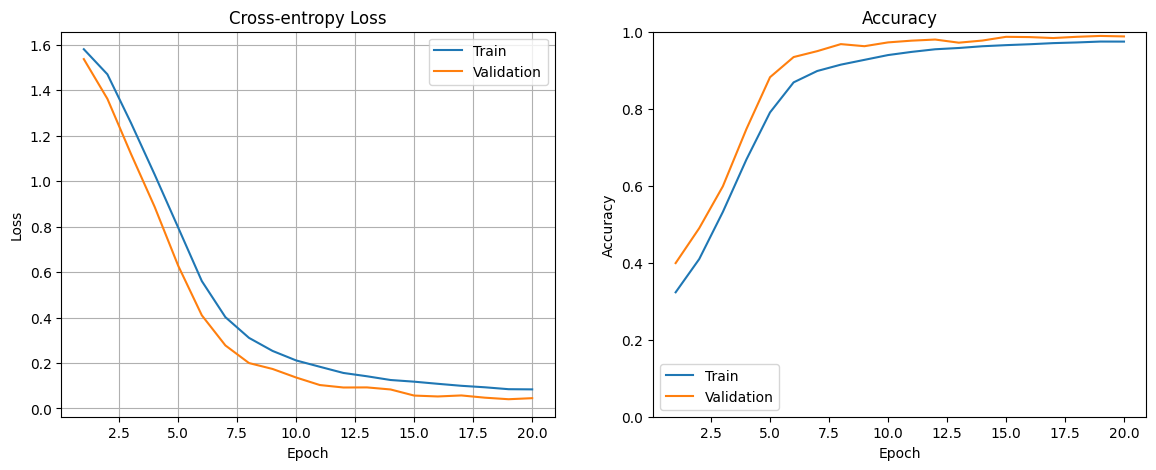

In [29]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(1, 2, figsize = (14,5))

# Plot cross-entropy loss
axes[0].plot(epochs, train_losses, label='Train')
axes[0].plot(epochs, val_losses, label='Validation')
axes[0].set_title('Cross-entropy Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Plot Accuracy
axes[1].plot(epochs, train_accs, label='Train')
axes[1].plot(epochs, val_accs, label='Validation')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0, 1)
axes[1].legend()

TODO next:
- Experiment with `num_workers` and `pin_memory=True` in `DataLoader` for training time optimalization.  
`num_workers` - Instead of loading batches sequentially in the main process, PyTorch can use **multiple CPU workers** to load data in parallel.
```
DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2) # 2-4 workers is better
```

  `pin_memory=True` - It allocates the batch tensors in page-locked (pinned) memory, which makes transferring data to the GPU faster. **Use only when using a GPU**.
- Near 100% so try: (data augumentation done), **learning rate decay** or **ReduceLROnPlateau**, one more convolutuinal block if necessary

<a id="8"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#000814;overflow:hidden"> 8. Calculate final benchmarks</div>

In [30]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from termcolor import colored
import torch
from datetime import datetime

# Set model to evaluation mode
model.eval()
y_true = []
y_pred_cm = [] # for confusion matrix
y_scores = [] # for ROC AUC
total_loss = 0
correct = 0
total = 0

loss_fn = torch.nn.CrossEntropyLoss()
start_time = datetime.now()

with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)

        output = model(X)  # (B, 5)
        probs = torch.softmax(output, dim=1) ### SOFTMAX FOR EVALUATION

        # Store for ROC AUC
        y_scores.extend(probs.cpu().numpy())
        y_true.extend(y.cpu().numpy())

        # For confusion matrix
        preds = output.argmax(dim=1)
        y_pred_cm.extend(preds.cpu().numpy())

        # Compute loss & accuracy
        total_loss += loss_fn(output, y).item()
        preds = output.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

elapsed_time = datetime.now() - start_time
avg_test_loss = total_loss / len(test_dataloader)
test_accuracy = correct / total

# Print summary
print(colored(f'\nLoss: {avg_test_loss:.4f}', 'cyan'))
print(colored(f'Accuracy: {test_accuracy:.4f}', 'cyan'))
print(colored(f'Duration: {elapsed_time}', 'cyan'))

# Prepare for ROC AUC
y_true = np.array(y_true)
y_scores = np.array(y_scores)
y_true_bin = label_binarize(y_true, classes=np.arange(unique_classes))  # (N, 5)


Loss: 0.0454
Accuracy: 0.9878
Duration: 0:00:13.193967


In [31]:
# Calculate ROC and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(unique_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


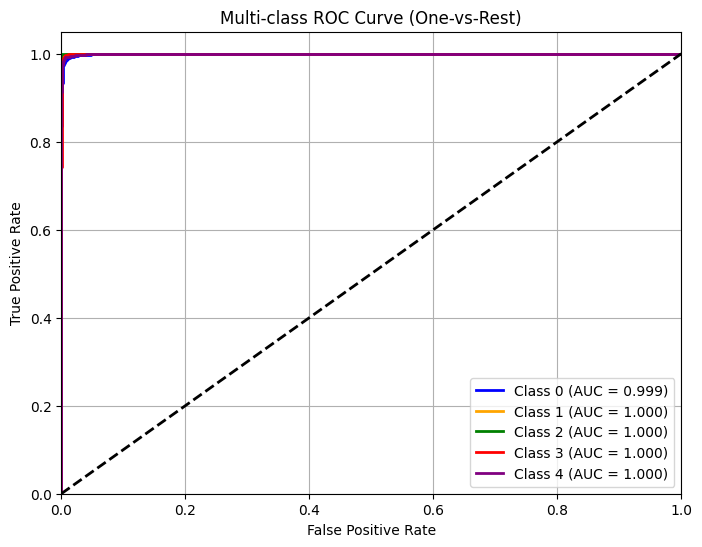

In [32]:
plt.figure(figsize=(8, 6))

colors = ['blue', 'orange', 'green', 'red', 'purple']
for i in range(unique_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.3f})")

# Diagonal line (random chance)
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [33]:
class_names = dataset.classes
class_names

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

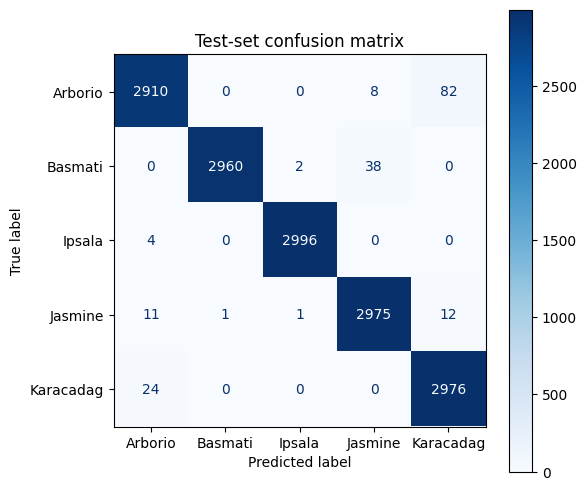

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = dataset.classes

cm = confusion_matrix(y_true, y_pred_cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = class_names)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap="Blues", ax=ax)
plt.title("Test-set confusion matrix")
plt.show()

<a id="9"></a>
# <div style="padding:20px;color:white;margin:0;font-size:20px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:#000814;overflow:hidden"> 9. Save the model</div>

In [35]:
# Save model

from google.colab import drive
drive.mount('/content/drive')

# Replace with your own path in Drive
model_state_dict_path = "/content/drive/MyDrive/my_rice_model_state_dict.pth"
model_path = "/content/drive/MyDrive/my_rice_model.pth"

Mounted at /content/drive


In [36]:
torch.save(model.state_dict(), model_state_dict_path)
torch.save(model, model_path)  # full model

In [37]:
model = NeuralNetwork(unique_classes)
model.load_state_dict(torch.load(model_state_dict_path))
model.to(device)
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense_layers): Sequential(
    (0): Linear(in_features=12